<a href="https://colab.research.google.com/github/szakmarynandor/FAKT-MLCourse/blob/main/stock_pred_hw06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock price prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

###Tesla részvény árfolyamának feltöltése

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tesla=pd.read_csv('/content/drive/My Drive/FAKT_ML/tesla.csv')

In [4]:
tesla.shape

(1570, 8)

In [5]:
tesla.head()

,Unnamed: 0,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,TSLA.Volume,TSLA.Adjusted,date
0,X2016.01.04,46.144001,46.276001,43.799999,44.681999,34135500.0,44.681999,2016-01-04
1,X2016.01.05,45.271999,45.377998,44.000000,44.686001,15934000.0,44.686001,2016-01-05
2,X2016.01.06,44.000000,44.009998,43.195999,43.807999,18895500.0,43.807999,2016-01-06
3,X2016.01.07,42.838001,43.688000,42.734001,43.130001,17771500.0,43.130001,2016-01-07
4,X2016.01.08,43.571999,44.088001,42.153999,42.200001,18140500.0,42.200001,2016-01-08


In [6]:
training_set = tesla.iloc[:, 6:7].values

In [7]:
training_set

array([[  44.681999],
       [  44.686001],
       [  43.807999],
       ...,
       [1013.919983],
       [1010.640015],
       [1010.640015]])

###Normalizálás

In [8]:
#normalizer = StandardScaler()

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
training_set_scaled

array([[0.01327699],
       [0.01328032],
       [0.01254937],
       ...,
       [0.82018452],
       [0.81745388],
       [0.81745388]])

In [11]:
X_train = []
y_train = []
for i in range(60, 1570):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
X_train.shape

(1510, 60, 1)

###LSTM modell

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
early_stopping_callback = EarlyStopping(patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=250, validation_split=0.1, callbacks=[early_stopping_callback], batch_size=32)

Epoch 1/250
43/43 [==============================] - 16s 108ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 2/250
43/43 [==============================] - 3s 63ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 3/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0016 - val_loss: 0.0099
Epoch 4/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0014 - val_loss: 0.0163
Epoch 5/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0012 - val_loss: 0.0144
Epoch 6/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 7/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 8/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0013 - val_loss: 0.0125
Epoch 9/250
43/43 [==============================] - 3s 64ms/step - loss: 7.8413e-04 - val_loss: 0.0068
Epoch 10/250
43/43 [==============================] - 3s 64ms/step - loss: 0.0014 - val_loss: 

###Előrejelzés

In [15]:
dataset_test = pd.read_csv('/content/drive/My Drive/FAKT_ML/tesla.csv')
real_stock_price = dataset_test.iloc[:, 6:7].values

In [16]:
real_stock_price

array([[  44.681999],
       [  44.686001],
       [  43.807999],
       ...,
       [1013.919983],
       [1010.640015],
       [1010.640015]])

In [17]:
dataset_total = pd.concat((tesla['TSLA.Close'], tesla['TSLA.Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [18]:
predicted_stock_price.shape

(20, 1)

In [19]:
real_stock_price.shape

(1570, 1)

###Eredmények ábrázolása

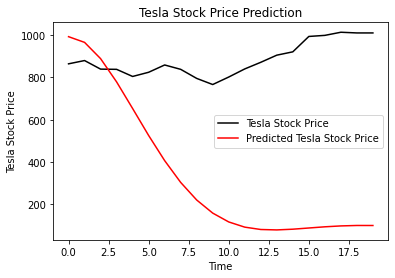

In [20]:
plt.plot(real_stock_price[1550:1570], color = 'black', label = 'Tesla Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

Elég érdekes predikció született...